Доступные столбцы в данных:
['Вопрос решен', 'Вопрос не решен ', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8']

Распределение классов:
positive
1    1547
0     188
Name: count, dtype: int64

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.67      0.10      0.17        41
           1       0.89      0.99      0.94       306

    accuracy                           0.89       347
   macro avg       0.78      0.55      0.55       347
weighted avg       0.86      0.89      0.85       347



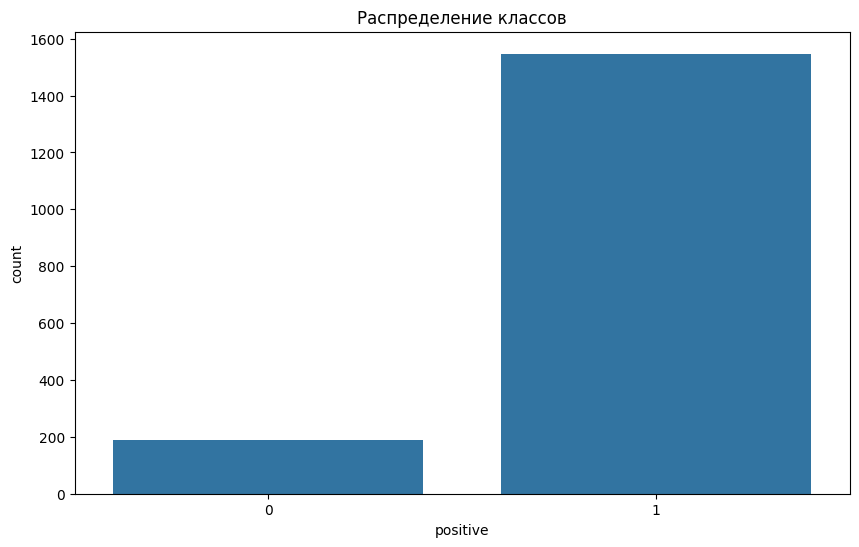

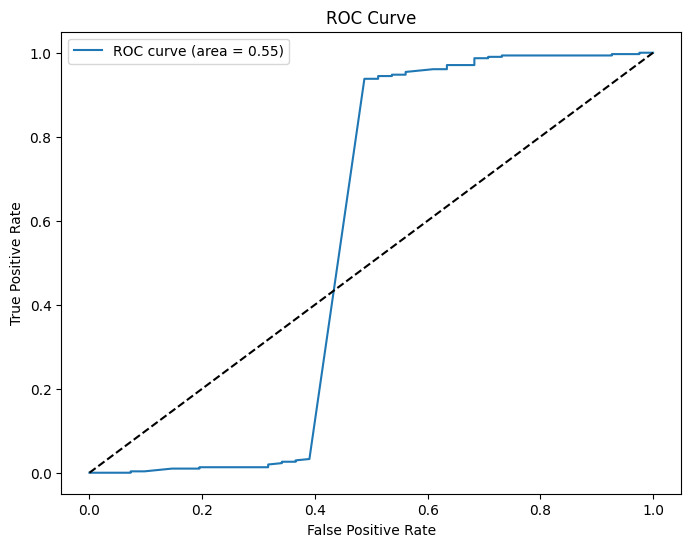

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from wordcloud import WordCloud
import numpy as np

# Загрузка данных
data = pd.read_csv('cleaned_comments.csv', sep='\t', encoding='utf-8')

# Проверка доступных столбцов
print("Доступные столбцы в данных:")
print(data.columns.tolist())

# Создаем целевую переменную, проверяя наличие каждого столбца
positive_columns = []
for col in ['Нравится качество выполнения заявки', 
           'Нравится качество работы сотрудников',
           'Нравится скорость отработки заявок',  # Обратите внимание на окончание "ок" вместо "ки"
           'Понравилось выполнение заявки']:
    if col in data.columns:
        positive_columns.append(col)
    else:
        print(f"Столбец '{col}' не найден в данных")

if not positive_columns:
    raise ValueError("Не найдено ни одного столбца для определения положительных отзывов")

# Создаем целевую переменную
data['positive'] = data[positive_columns].any(axis=1).astype(int)

# Проверяем распределение классов
print("\nРаспределение классов:")
print(data['positive'].value_counts())

# Создаем текстовые данные
comments = data.fillna('').apply(lambda row: ' '.join(str(row[col]) for col in data.columns if col not in positive_columns and col != 'positive'), axis=1)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(comments, data['positive'], test_size=0.2, random_state=42)

# Векторизация текста
vectorizer = CountVectorizer(stop_words=['спасибо', 'большое', 'огромное'], 
                           max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Обучение модели
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# Оценка модели
y_pred = nb_classifier.predict(X_test_vec)
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))

# Визуализации
plt.figure(figsize=(10, 6))
sns.countplot(x=data['positive'])
plt.title('Распределение классов')
plt.show()



# ROC-кривая
y_prob = nb_classifier.predict_proba(X_test_vec)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

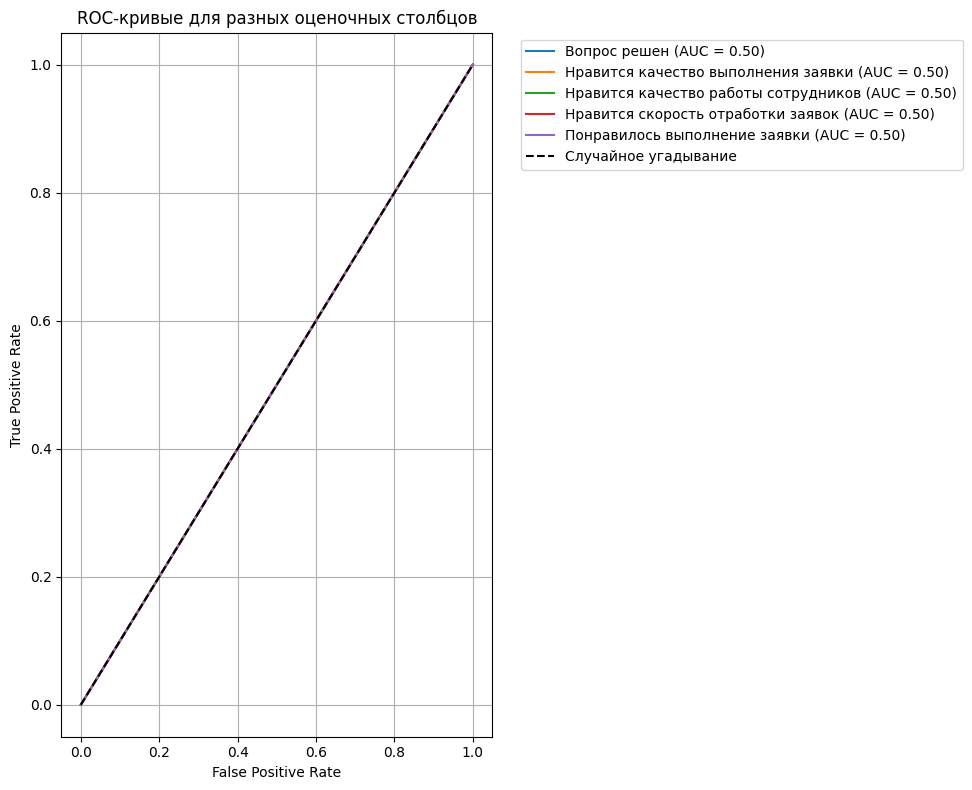

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from textblob import TextBlob

# Загрузка данных
data = pd.read_csv('cleaned_comments.csv', sep='\t')

# Список оценочных столбцов
rating_columns = [
    'Вопрос решен', 
    'Вопрос не решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки'
]

# Анализ тональности комментариев
def get_sentiment(text):
    if pd.isna(text):
        return 0
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

data['sentiment'] = data['Unnamed: 6'].apply(get_sentiment)

# Создаем фигуру для всех ROC-кривых
plt.figure(figsize=(10, 8))

# Обучаем модель для каждого оценочного столбца
for col in rating_columns:
    # Создаем целевую переменную (1 если есть оценка, 0 если нет)
    if col in data.columns:
        y = data[col].apply(lambda x: 1 if pd.notna(x) else 0)
        
        # Пропускаем столбцы с недостаточным количеством положительных примеров
        if sum(y) < 10:
            print(f"Столбец {col} пропущен - недостаточно данных")
            continue
            
        # Выбираем признаки
        X = data[['sentiment']]
        
        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42)
        
        # Обучение модели
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        
        # Предсказание вероятностей
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # ROC AUC
        roc_auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        # Построение ROC-кривой
        plt.plot(fpr, tpr, label=f'{col} (AUC = {roc_auc:.2f})')

# Добавляем диагональ для сравнения
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')

# Настройки графика
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для разных оценочных столбцов')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      1.00      1.00       409

    accuracy                           1.00       412
   macro avg       1.00      0.67      0.75       412
weighted avg       1.00      1.00      0.99       412

          feature  importance
691      проблема    0.231642
762        решена    0.220111
425            не    0.042507
936     устранена    0.035527
727      работает    0.029591
332          лифт    0.021907
191      доводчик    0.014744
108       входная    0.013670
494    оперативно    0.013425
983            эл    0.012947
642        потому    0.012653
600          пока    0.011828
647         почту    0.011050
845  специалистом    0.010984
882           так    0.010757
903          того    0.010619
200    достаточно    0.010600
826         снова    0.010137
41         быстро    0.010081
777         ручки    0.009295


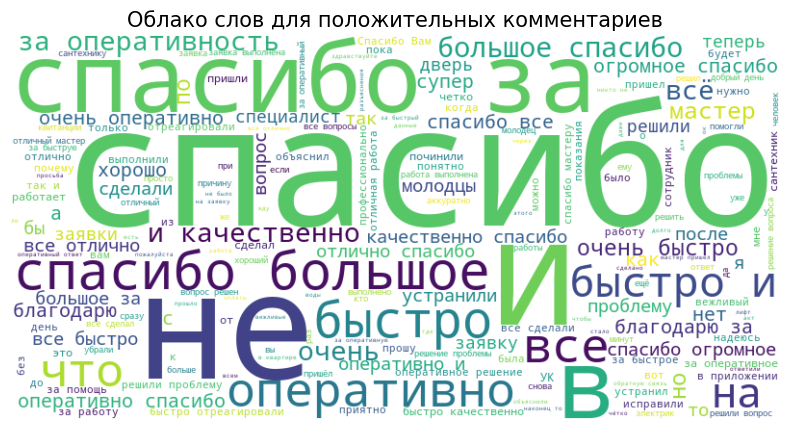

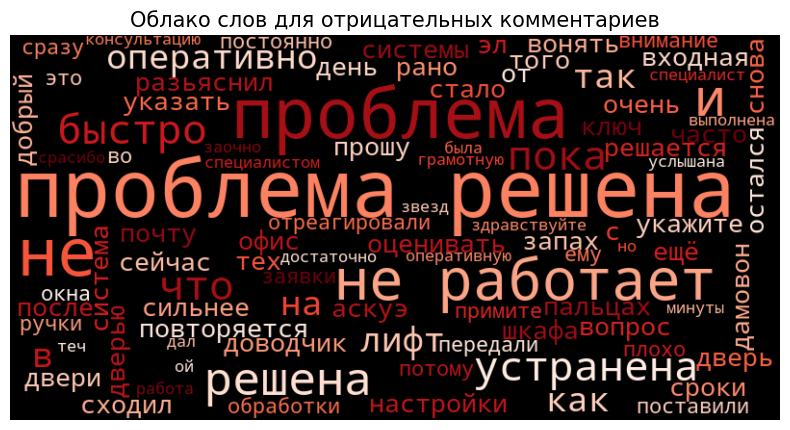

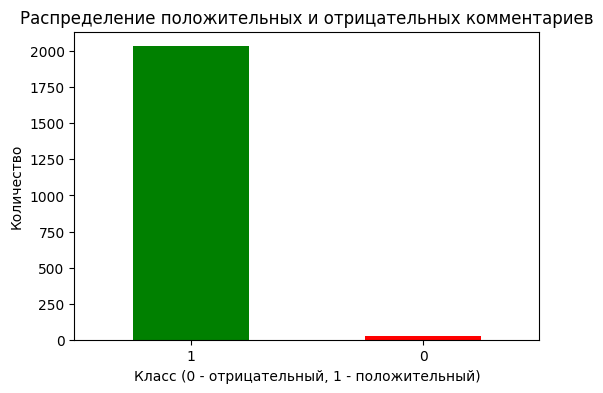

Комментарий: 'спасибо за быструю работу' - Положительный
Комментарий: 'проблема не решена' - Отрицательный
Комментарий: 'все отлично, хороший сервис' - Положительный


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Загрузка данных
df = pd.read_csv('cleaned_comments.csv', encoding='utf-8', delimiter='\t')

# Сбор всех комментариев в один список
comments = []
for col in df.columns:
    comments.extend(df[col].dropna().tolist())

# Очистка комментариев
cleaned_comments = []
for comment in comments:
    if isinstance(comment, str):
        clean_comment = re.sub(r'\s+', ' ', comment).strip()
        cleaned_comments.append(clean_comment)

# Создание меток
labels = []
for comment in cleaned_comments:
    if any(word in comment.lower() for word in ['спасибо', 'благодарю', 'отлично', 'хорошо', 'супер']):
        labels.append(1)  # положительный
    elif any(word in comment.lower() for word in ['проблема', 'не работает', 'не решено', 'плохо']):
        labels.append(0)  # отрицательный
    else:
        labels.append(1)  # нейтральные считаем положительными для примера

# Векторизация текста
vectorizer = TfidfVectorizer(max_features=1000, stop_words=['спасибо', 'благодарю'])
X = vectorizer.fit_transform(cleaned_comments)
y = labels

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Оценка модели
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Важность признаков
feature_importances = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importances.head(20))

# 1. Облако слов для положительных комментариев
positive_comments = ' '.join([comment for comment, label in zip(cleaned_comments, labels) if label == 1])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Облако слов для положительных комментариев', fontsize=15)
plt.axis('off')
plt.show()

# 2. Облако слов для отрицательных комментариев
negative_comments = ' '.join([comment for comment, label in zip(cleaned_comments, labels) if label == 0])
if negative_comments:  # Проверка на пустоту
    wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_comments)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Облако слов для отрицательных комментариев', fontsize=15)
    plt.axis('off')
    plt.show()

# 3. График распределения классов
plt.figure(figsize=(6, 4))
pd.Series(labels).value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Распределение положительных и отрицательных комментариев')
plt.xlabel('Класс (0 - отрицательный, 1 - положительный)')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()




# Функция предсказания
def predict_sentiment(text):
    text_vector = vectorizer.transform([text])
    prediction = rf_model.predict(text_vector)[0]
    return "Положительный" if prediction == 1 else "Отрицательный"

# Примеры использования
test_comments = [
    "спасибо за быструю работу",
    "проблема не решена",
    "все отлично, хороший сервис",
    
]

for comment in test_comments:
    print(f"Комментарий: '{comment}' - {predict_sentiment(comment)}")


Результаты кросс-валидации:
F1-метрика для каждого фолда: [0.9852858  0.99454478 0.98707875 0.98788787 0.98731991]
Средняя F1-метрика: 0.988 ± 0.003

Отчет о классификации на тестовых данных:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.99      1.00      1.00       407

    accuracy                           0.99       412
   macro avg       0.83      0.70      0.75       412
weighted avg       0.99      0.99      0.99       412



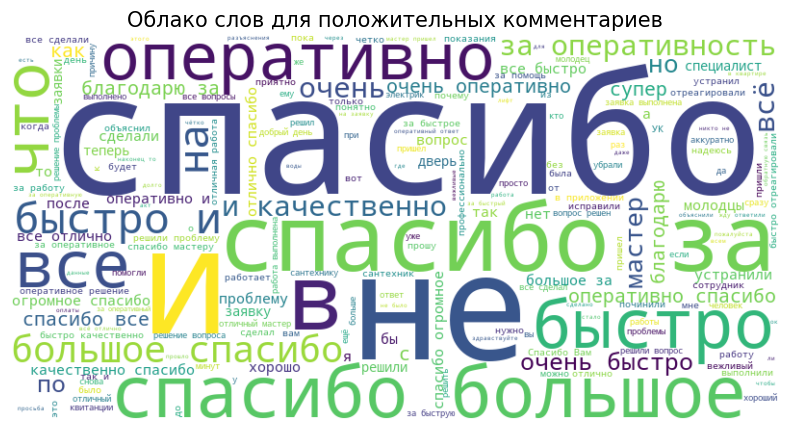

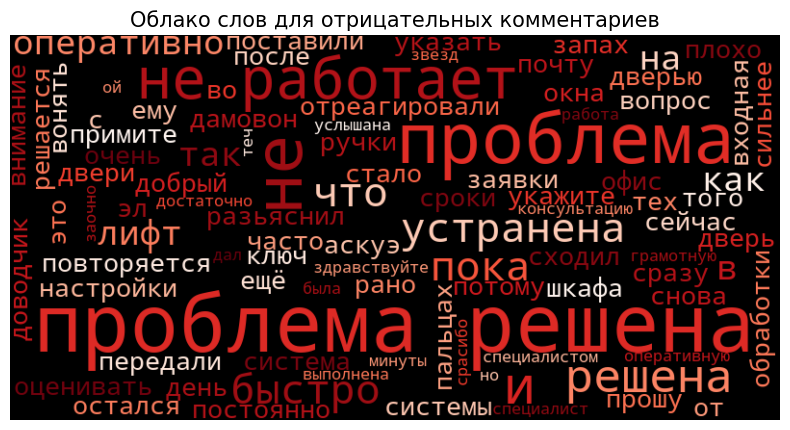

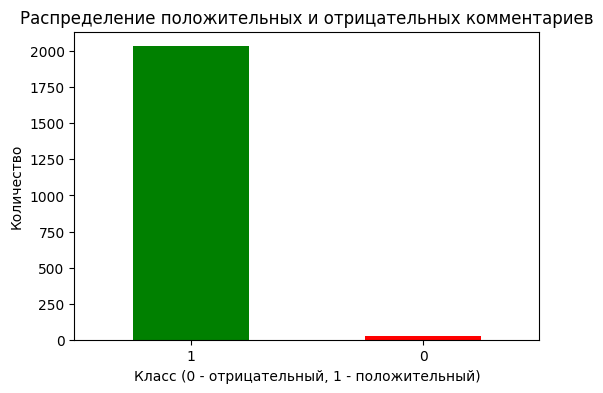

C:\Users\VikA\AppData\Local\Temp\ipykernel_5808\1259758925.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


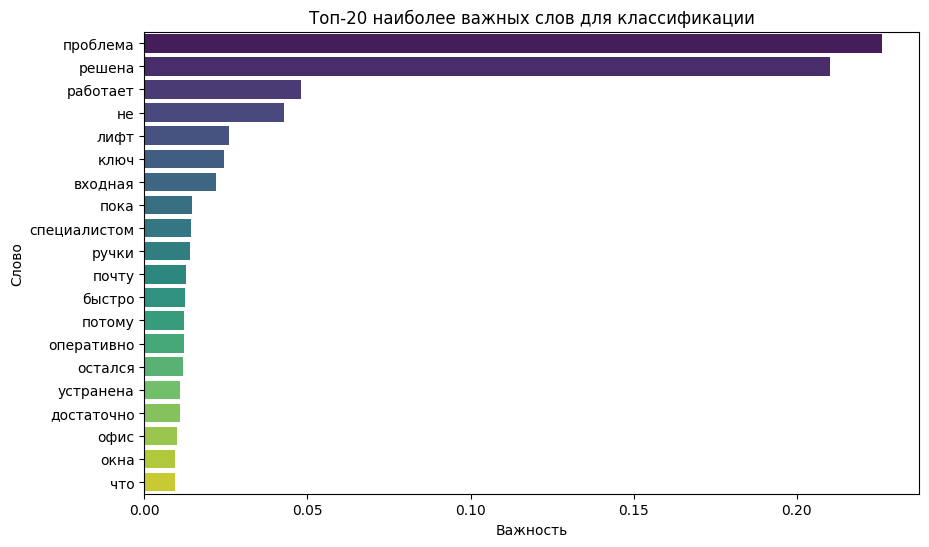

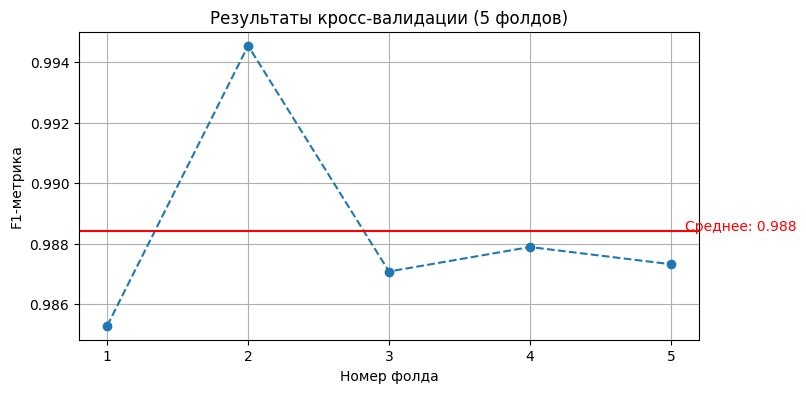


Примеры предсказаний:
Комментарий: 'спасибо за быструю работу' - Положительный
Комментарий: 'проблема не решена' - Отрицательный
Комментарий: 'все отлично, хороший сервис' - Положительный


In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np

# Загрузка данных
df = pd.read_csv('cleaned_comments.csv', encoding='utf-8', delimiter='\t')

# Сбор всех комментариев в один список
comments = []
for col in df.columns:
    comments.extend(df[col].dropna().tolist())

# Очистка комментариев
cleaned_comments = []
for comment in comments:
    if isinstance(comment, str):
        clean_comment = re.sub(r'\s+', ' ', comment).strip()
        cleaned_comments.append(clean_comment)

# Создание меток
labels = []
for comment in cleaned_comments:
    if any(word in comment.lower() for word in ['спасибо', 'благодарю', 'отлично', 'хорошо', 'супер']):
        labels.append(1)  # положительный
    elif any(word in comment.lower() for word in ['проблема', 'не работает', 'не решено', 'плохо']):
        labels.append(0)  # отрицательный
    else:
        labels.append(1)  # нейтральные считаем положительными для примера

# Векторизация текста
vectorizer = TfidfVectorizer(max_features=1000, stop_words=['спасибо', 'благодарю'])
X = vectorizer.fit_transform(cleaned_comments)
y = np.array(labels)  # Преобразуем в numpy array для кросс-валидации

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создание модели
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Кросс-валидация
print("\nРезультаты кросс-валидации:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='f1_weighted')

print(f"F1-метрика для каждого фолда: {cv_scores}")
print(f"Средняя F1-метрика: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

# Обучение модели на полном тренировочном наборе
rf_model.fit(X_train, y_train)

# Оценка модели на тестовом наборе
y_pred = rf_model.predict(X_test)
print("\nОтчет о классификации на тестовых данных:")
print(classification_report(y_test, y_pred))

# Важность признаков
feature_importances = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# 1. Облако слов для положительных комментариев
positive_comments = ' '.join([comment for comment, label in zip(cleaned_comments, labels) if label == 1])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Облако слов для положительных комментариев', fontsize=15)
plt.axis('off')
plt.show()

# 2. Облако слов для отрицательных комментариев
negative_comments = ' '.join([comment for comment, label in zip(cleaned_comments, labels) if label == 0])
if negative_comments:
    wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_comments)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Облако слов для отрицательных комментариев', fontsize=15)
    plt.axis('off')
    plt.show()

# 3. График распределения классов
plt.figure(figsize=(6, 4))
pd.Series(labels).value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Распределение положительных и отрицательных комментариев')
plt.xlabel('Класс (0 - отрицательный, 1 - положительный)')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()


# 4. Топ-20 важных слов
top_features = feature_importances.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Топ-20 наиболее важных слов для классификации')
plt.xlabel('Важность')
plt.ylabel('Слово')
plt.show()

# 5. График результатов кросс-валидации
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='--')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='-')
plt.text(5.1, np.mean(cv_scores), f'Среднее: {np.mean(cv_scores):.3f}', color='r')
plt.title('Результаты кросс-валидации (5 фолдов)')
plt.xlabel('Номер фолда')
plt.ylabel('F1-метрика')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

# Функция предсказания
def predict_sentiment(text):
    text_vector = vectorizer.transform([text])
    prediction = rf_model.predict(text_vector)[0]
    return "Положительный" if prediction == 1 else "Отрицательный"

# Примеры использования
test_comments = [
    "спасибо за быструю работу",
    "проблема не решена",
    "все отлично, хороший сервис",
    
]

print("\nПримеры предсказаний:")
for comment in test_comments:
    print(f"Комментарий: '{comment}' - {predict_sentiment(comment)}")

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder, binarize

# Загрузка данных
df = pd.read_csv('cleaned_comments.csv', delimiter='\t')

# Заполнение пропущенных значений
df.fillna('', inplace=True)

# Преобразование текстовых меток в бинарные
target_columns = ['Вопрос решен', 'Вопрос не решен', 'Нравится качество выполнения заявки', 
                 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 
                 'Понравилось выполнение заявки']

for col in target_columns:
    df[col] = df[col].apply(lambda x: 1 if str(x).strip() != '' else 0)

# Разделение на признаки и целевую переменную
X = df['Unnamed: 6'].fillna('') + ' ' + df['Unnamed: 7'].fillna('') + ' ' + df['Unnamed: 8'].fillna('')
y = df[target_columns]# Создадим pipeline для обработки текста и классификации
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, stop_words=['спасибо'])),
    ('clf', LogisticRegression(max_iter=1000))
])

# Настройки для кросс-валидации и графиков
cv = StratifiedKFold(n_splits=5)
plt.figure(figsize=(15, 10))

# Обучим отдельную модель для каждого целевого столбца
for i, target_col in enumerate(target_columns):
    print(f"\nАнализ для столбца: {target_col}")
    
    # Преобразуем целевую переменную
    y_target = y[target_col]
    
    # Разделим данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_target, test_size=0.3, random_state=42)
    
    # Обучим модель
    pipeline.fit(X_train, y_train)
    
    # Кросс-валидация
    cv_scores = cross_val_score(pipeline, X, y_target, cv=cv, scoring='roc_auc')
    print(f"Средний ROC-AUC по кросс-валидации: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    
    # Предсказания вероятностей для тестовой выборки
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Рассчитаем ROC-кривую
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Построим график ROC
    plt.subplot(2, 3, i+1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC для "{target_col}"')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

KeyError: 'Вопрос не решен'